In [17]:
from astroquery.jplhorizons import Horizons
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import calendar

In [2]:
DATA_PATH='data/'

In [3]:
month_num_dic={month: index for index, month in enumerate(calendar.month_abbr) if month}

In [42]:
num_month_dict = {
    1: 'En.',
    2: 'Febr.',
    3: 'Mar.',
    4: 'Apr.',
    5: 'May.',
    6: 'Jun.',
    7: 'Jul.',
    8: 'Ago.',
    9: 'Sep.',
    10: 'Oct.',
    11: 'Nov.',
    12: 'Dic.'
}

# JPL Horizons Request
- Target Body : Moon [301]

In [16]:
obj = Horizons(
    id='301',
    id_type='majorbody',
    location='399',
    epochs={
        'start':'2021-05-29', 
        'stop':'2021-05-31',
        'step':'30m'
    },
    
)

In [34]:
obj = Horizons(
    id='301',
    id_type='majorbody',
    location={
        'lon': -90.57204500000002,
        'lat': 14.524373333333331,
        'elevation': 381.6
    },
    epochs={
        'start':'2021-05-31 00:00:00', 
        'stop':'2021-05-31 23:59:59',
        'step':'1h'
    },  
)

In [35]:
eph = obj.ephemerides(quantities='4')

In [36]:
data_eph = eph.to_pandas()

In [37]:
data_eph['datetime'] = pd.to_datetime(data_eph['datetime_str'])

In [38]:
data_eph['hour'] = data_eph['datetime'].dt.hour

In [39]:
data_eph.head()

,targetname,datetime_str,datetime_jd,solar_presence,flags,AZ,EL,datetime,hour
0,Moon (301),2021-May-31 00:00,2.459366e+06,*,,111.846687,-67.595283,2021-05-31 00:00:00,0
1,Moon (301),2021-May-31 01:00,2.459366e+06,*,,106.924002,-54.588251,2021-05-31 01:00:00,1
2,Moon (301),2021-May-31 02:00,2.459366e+06,*,,106.038868,-41.342539,2021-05-31 02:00:00,2
3,Moon (301),2021-May-31 03:00,2.459366e+06,,,106.840763,-28.044282,2021-05-31 03:00:00,3
4,Moon (301),2021-May-31 04:00,2.459366e+06,,m,108.728425,-14.781694,2021-05-31 04:00:00,4


<AxesSubplot:xlabel='AZ', ylabel='EL'>

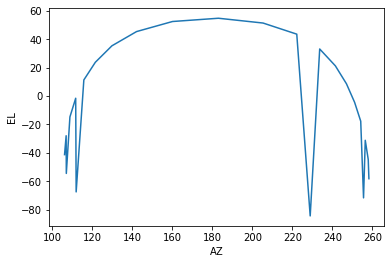

In [40]:
sns.lineplot(data=data_eph, x='AZ', y='EL')

<AxesSubplot:xlabel='hour', ylabel='AZ'>

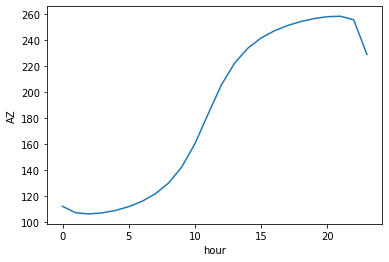

In [41]:
sns.lineplot(data=data_eph, x='hour', y='AZ')

<AxesSubplot:xlabel='hour', ylabel='EL'>

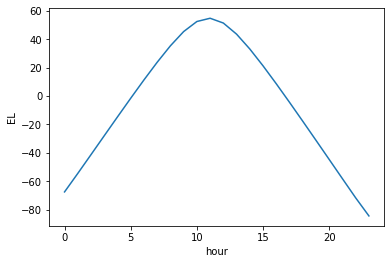

In [42]:
sns.lineplot(data=data_eph, x='hour', y='EL')

## Moon data 2021

In [26]:
moon_data = pd.read_csv(DATA_PATH+"eph_data_20210101_20210831_15m.csv")

In [27]:
locations = moon_data[['lat', 'lon', 'alt']].drop_duplicates().copy()
locations.reset_index(drop=True, inplace=True)
locations['location']= 'location_'+ locations.index.astype(str)

In [28]:
locations

,lat,lon,alt,location
0,14.524373,-90.572045,381.6,location_0
1,14.583000,-90.533000,1488.0,location_1


In [29]:
moon_data['datetime'] = pd.to_datetime(moon_data['datetime'], utc=True)

In [30]:
moon_data['datetime_GT'] = moon_data['datetime'].dt.tz_convert('America/Guatemala')

In [31]:
#import pytz
#pytz.all_timezones

In [32]:
moon_data['mes'] = moon_data['datetime_GT'].dt.month
moon_data['dia'] = moon_data['datetime_GT'].dt.day
moon_data['hora'] = moon_data['datetime_GT'].dt.day

In [33]:
moon_data = moon_data[moon_data['mes']!=9]

In [34]:
moon_data = pd.merge(moon_data, locations, on=['lat', 'lon', 'alt'], how='left')

Text(0, 0.5, 'Altitud [deg]')

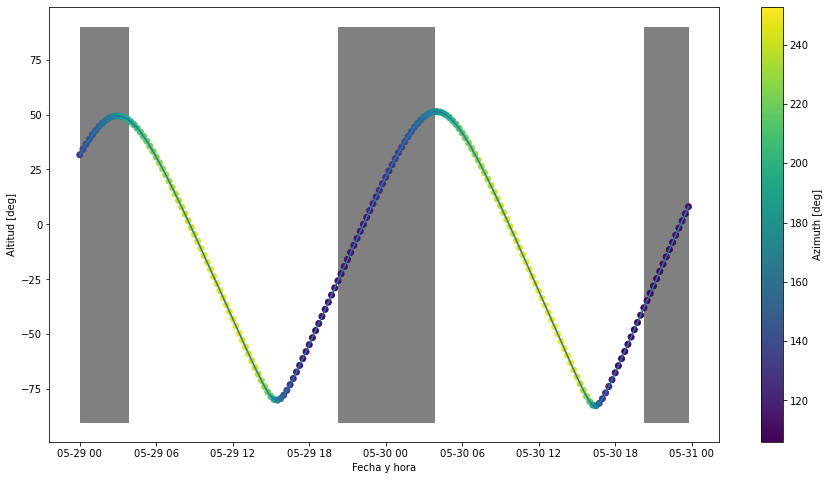

In [35]:
may_data = moon_data[(moon_data['mes']==5)
                     &(moon_data['location']=='location_0')
                     &(moon_data['dia'].isin([29, 30]))]
plt.figure(figsize = (15,8))
sns.lineplot(data=may_data, x='datetime_GT', y='EL')
plt.scatter(may_data['datetime'], may_data['EL'],
            c=may_data['AZ'],cmap='viridis')
plt.colorbar().set_label('Azimuth [deg]')
plt.fill_between(may_data['datetime_GT'],-90, 90,
                 may_data['solar_presence'].isnull(), color='0.5', zorder=0)
plt.xlabel('Fecha y hora')
plt.ylabel('Altitud [deg]')

Text(0, 0.5, 'Altitud [deg]')

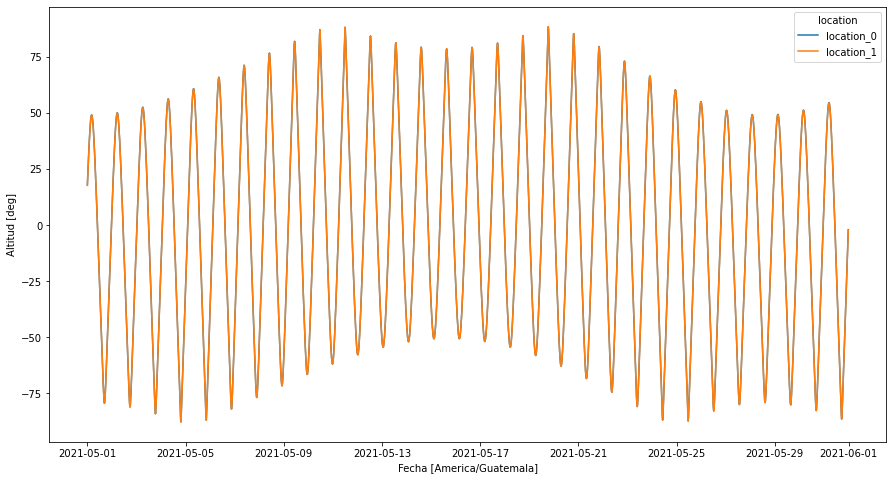

In [36]:
may_data = moon_data[moon_data['mes']==5]
plt.figure(figsize = (15,8))
sns.lineplot(data=may_data, x='datetime_GT', y='EL', hue='location')
plt.xlabel('Fecha [America/Guatemala]')
plt.ylabel('Altitud [deg]')

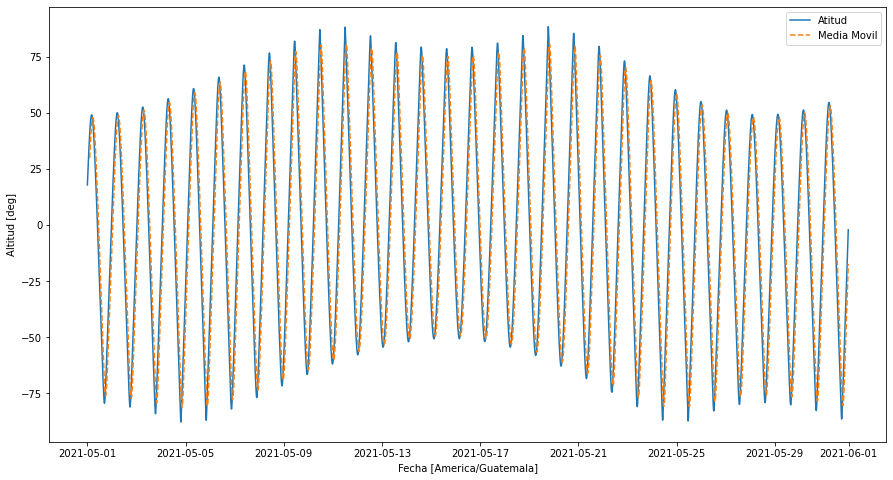

In [70]:
may_data = moon_data[(moon_data['mes']==5)&(moon_data['location']=='location_0')].copy()

rolling_window = 10
may_data['rolling_mean_EL'] = may_data['EL'].rolling(rolling_window).mean()

plt.figure(figsize = (15,8))
plt.plot(may_data['datetime_GT'], may_data['EL'], label="Atitud")
plt.plot(may_data['datetime_GT'], may_data['rolling_mean_EL'], linestyle="--", label="Media Movil")
plt.legend()
plt.xlabel('Fecha [America/Guatemala]')
plt.ylabel('Altitud [deg]')

plt.savefig('alt_media_movil.png')

<Figure size 1440x1080 with 0 Axes>

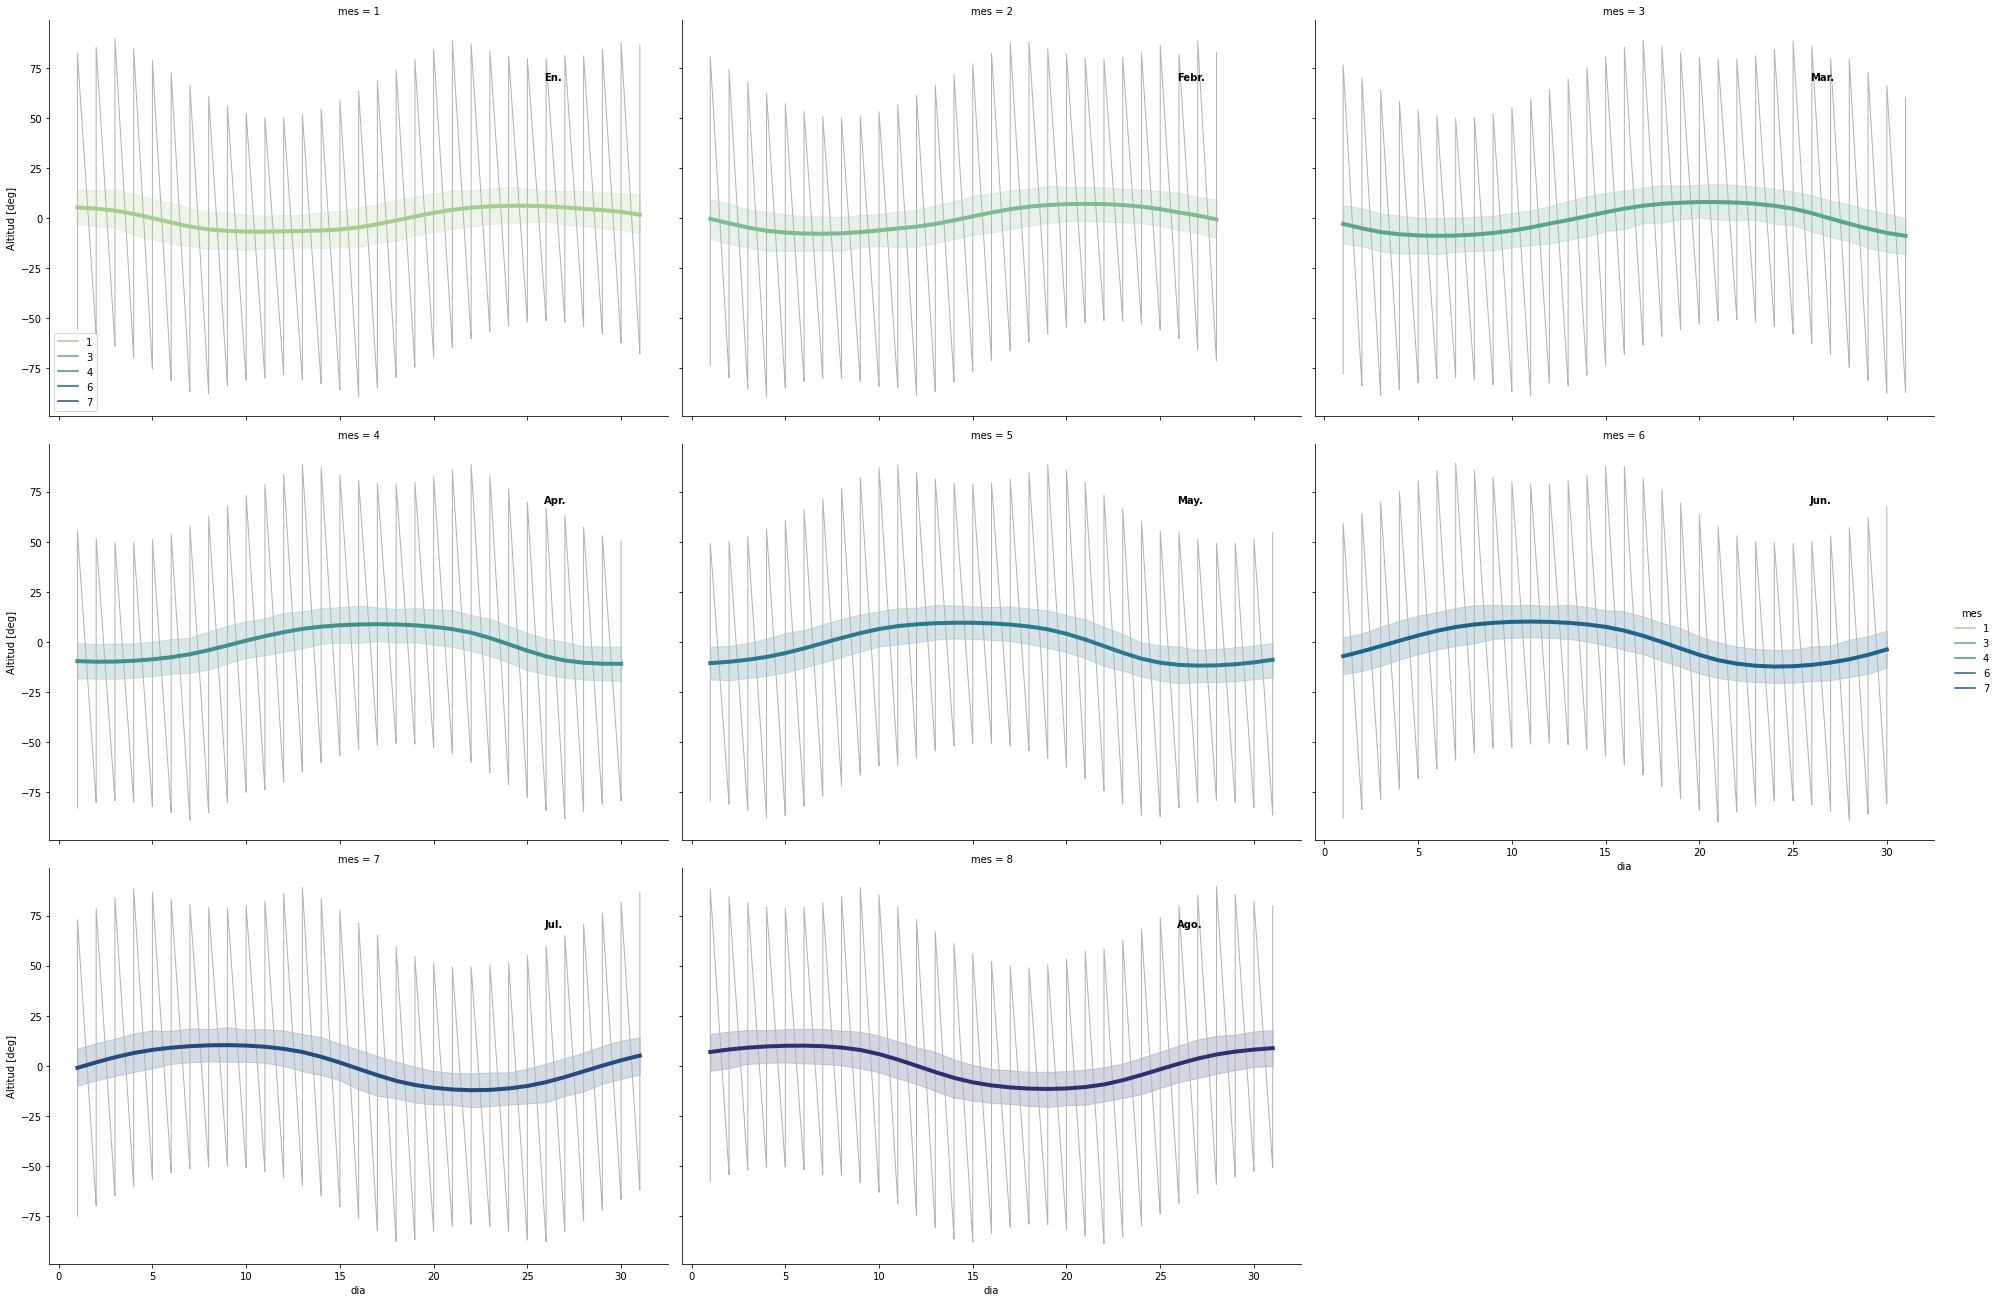

In [55]:
plt.figure(figsize = (20,15))
g = sns.relplot(
    data=moon_data[(moon_data['location']=='location_0') &(moon_data['mes'].isin([1,2,3,4,5,6,7,8]))], 
    x='dia', y='EL', col='mes', hue='mes', 
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=6, aspect=1.5
)

# Iterate over each subplot to customize further
for month, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, num_month_dict[month], transform=ax.transAxes, fontweight="bold")

    sns.lineplot(
        data=moon_data[moon_data['mes']==month], x="dia", y="EL", units="mes",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    ax.set_ylabel('Altitud [deg]')
plt.savefig('elevation_month.png')

<AxesSubplot:xlabel='datetime', ylabel='AZ'>

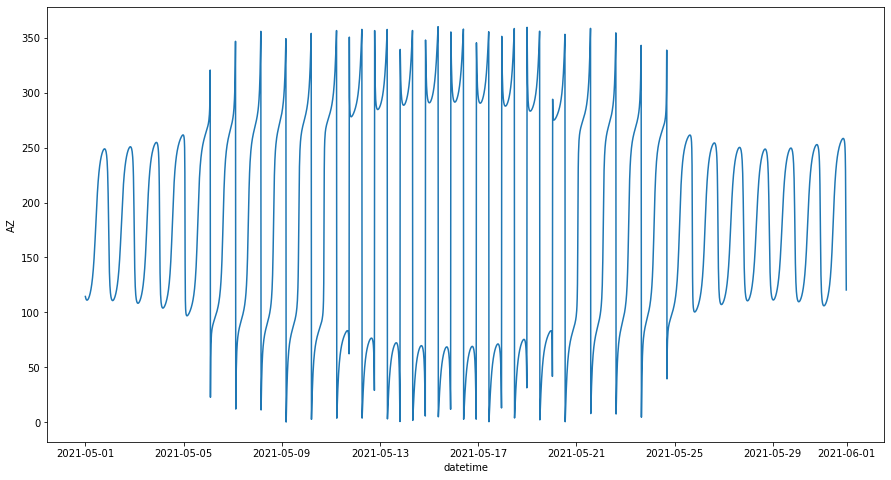

In [21]:
may_data = moon_data[moon_data['month']==5]
plt.figure(figsize = (15,8))
sns.lineplot(data=may_data, x='datetime', y='AZ')

<Figure size 1440x1080 with 0 Axes>

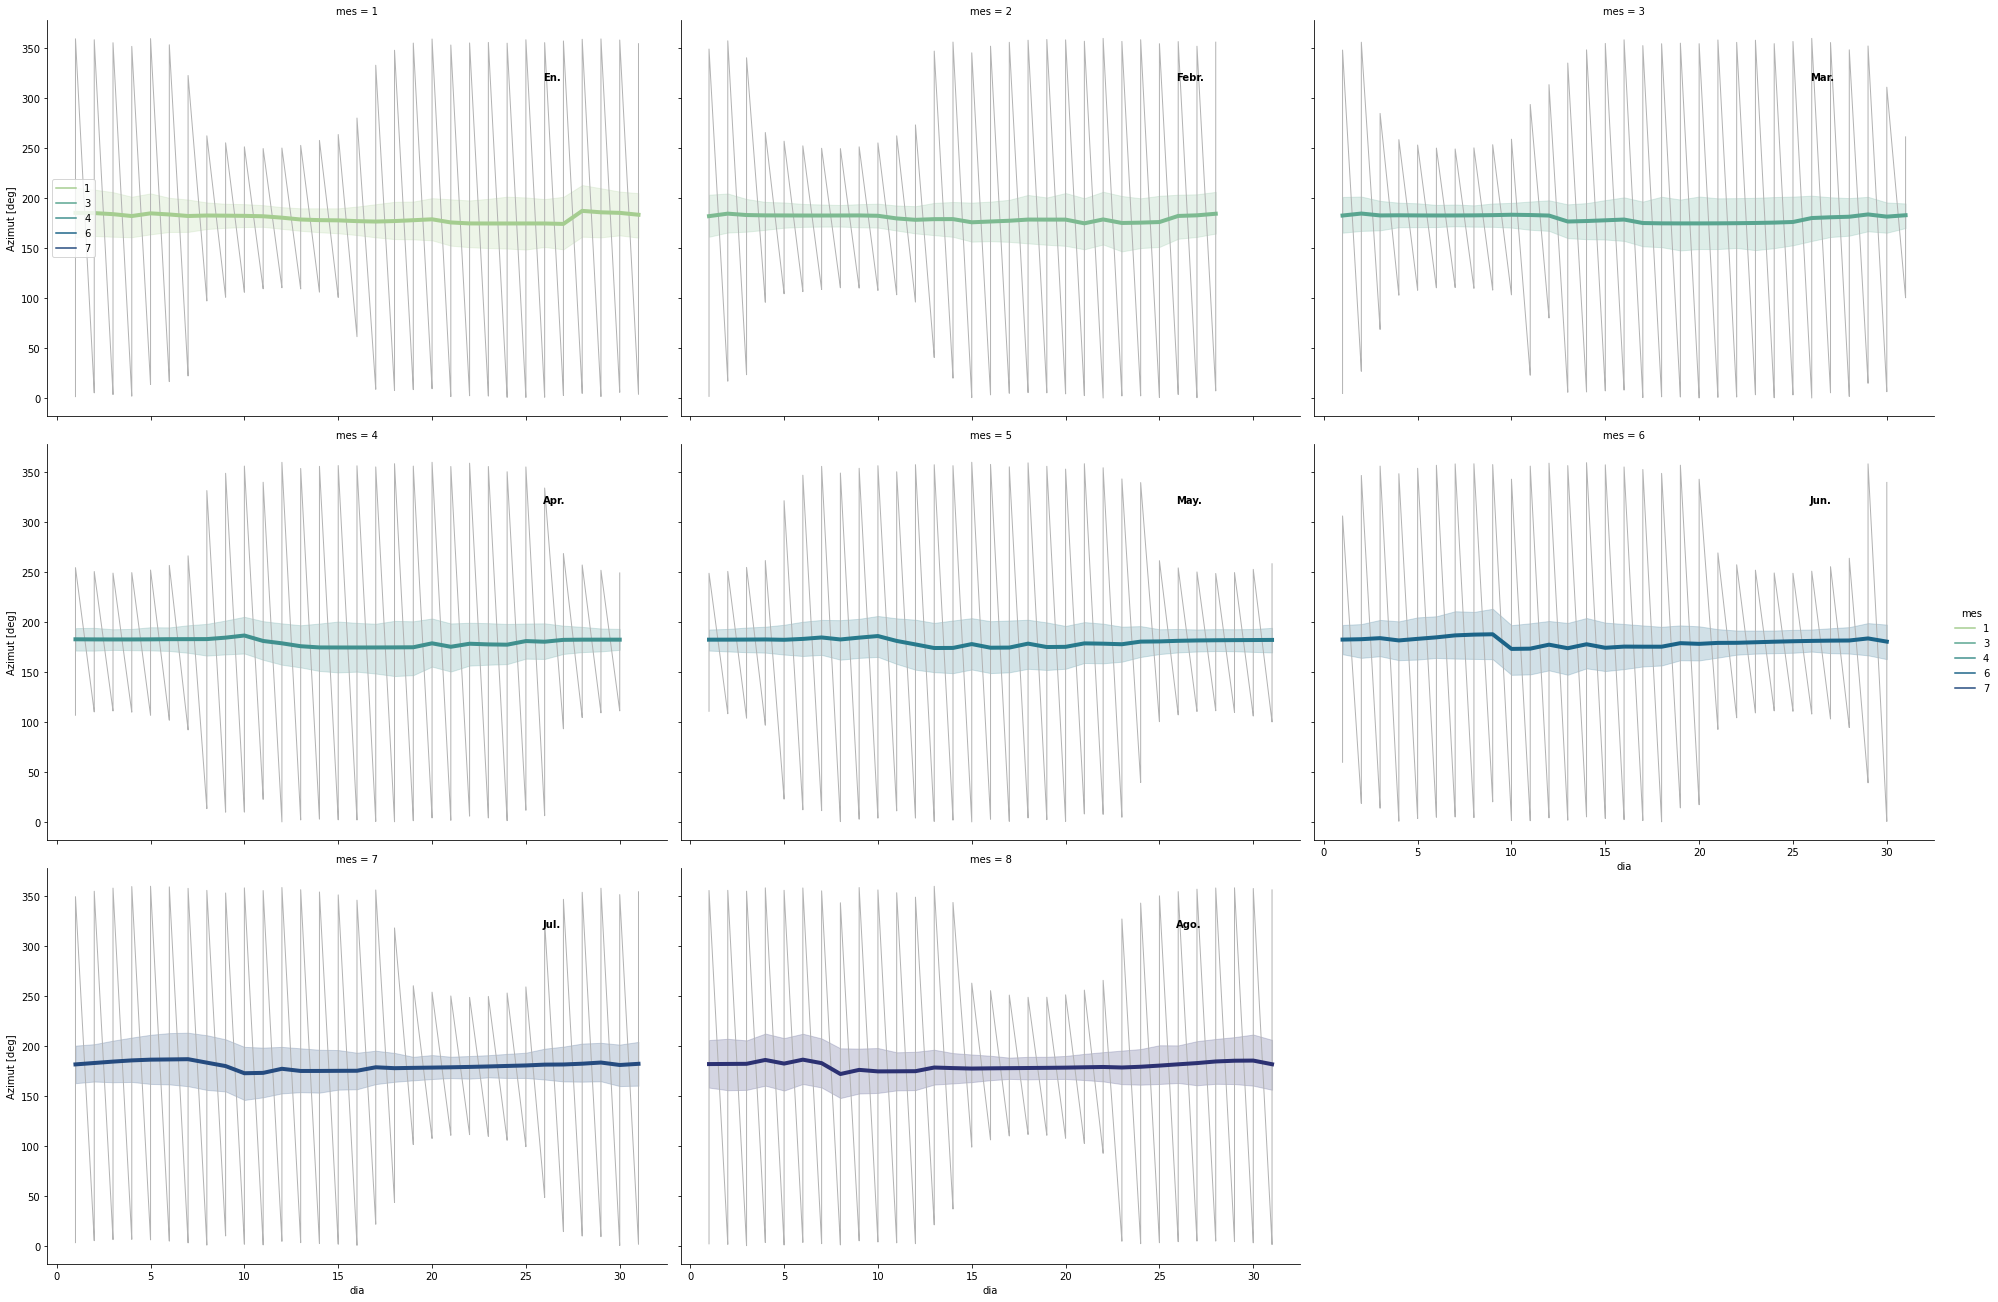

In [54]:
plt.figure(figsize = (20,15))
g = sns.relplot(
    data=moon_data[(moon_data['location']=='location_0') &(moon_data['mes'].isin([1,2,3,4,5,6,7,8]))], 
    x='dia', y='AZ', col='mes', hue='mes', 
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=6, aspect=1.5
)

# Iterate over each subplot to customize further
for month, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, num_month_dict[month], transform=ax.transAxes, fontweight="bold")

    sns.lineplot(
        data=moon_data[moon_data['mes']==month], x="dia", y="AZ", units="mes",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    ax.set_ylabel('Azimut [deg]')
plt.savefig('azimut_month.png')